In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmasher as cmr
from matplotlib.colors import ListedColormap


from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.stats import bootstrap
import astropy.units as u
from PIL import Image

import os
from pathlib import Path
import requests
from tqdm.notebook import tqdm

ROOT = Path('../..').resolve()
results_dir = ROOT/'results/xSAGA-init'

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

#cosmology
c = FlatLambdaCDM(H0=70, Om0=0.3)


# Examine CNN cross-validation results

In [55]:
df = pd.read_csv(ROOT/'data/saga-vision-results/kfold-train-low_z.csv', dtype={'OBJID': str})
df.sample(3, random_state=42)

,OBJID,RA,DEC,SPEC_Z,SPEC_FLAG,HAS_SAT_Z,HOSTID,R_MAG,is_low_z,kfold_split,pred_low_z
12845,3427670000000003353,219.751115,2.046522,0.208251,1,0,nsa145372,20.48,False,True,0.279393
15963,3327180000000003456,227.662018,0.222463,0.051001,1,0,nsa145879,20.00,False,True,0.296076
29049,5816250000000002185,210.894188,49.283592,0.428296,1,0,nsa69028,20.62,False,True,0.279473


## Check *satellites*

In [56]:
saga_sats = pd.read_csv(ROOT/'data/saga_stage2_sats.csv')
saga_sats.sample(3, random_state=42)

,HOST_COMMON_NAME,OBJID,RA,DEC,D_PROJ,DELTA_HRV,R,R_ABS,GR,MU_EFF,LOG_STELLAR_MASS,H_ALPHA,Z_SOURCE,INTERNAL_HOSTID,INTERNAL_OBJID
26,NGC2967,NSA-195,145.3209,0.7711,248,65,16.85,-15.5,0.33,20.64,7.83,Y,SDSS,nsa32,195
111,NGC7166,DES-247092888,330.5717,-43.2322,206,-132,18.21,-14.4,0.45,23.52,7.52,Y,AAT,pgc67817,247092888
81,NGC6181,LS-444338-475,248.2119,19.9001,81,57,19.14,-13.5,0.45,24.37,7.15,N,PAL,nsa147100,4443380000000000475


In [57]:
coords = SkyCoord(df[['RA', 'DEC']].values, unit=u.deg)
saga_coords = SkyCoord(saga_sats[['RA', 'DEC']].values, unit=u.deg)

idx, sep, _ = saga_coords.match_to_catalog_sky(coords)
coords.shape, saga_coords.shape, idx.shape, sum(sep < 1*u.arcsec)

((30760,), (127,), (127,), 127)

In [58]:
sats = pd.concat([saga_sats, df.iloc[idx].reset_index()], axis=1).copy()

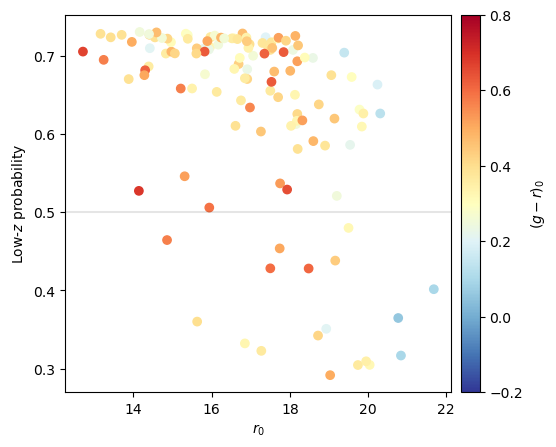

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=100)

sc = ax.scatter(sats.R, sats.pred_low_z, c=sats.GR, cmap='RdYlBu_r', vmin=-0.2, vmax=0.8)

ax.axhline(0.5, color='k', alpha=0.1)

ax.set_ylabel('Low-$z$ probability')
ax.set_xlabel(r'$r_0$')

cb = fig.colorbar(sc, pad=0.02)
cb.set_label(r'$(g-r)_0$')

One possible trend is that the brighter galaxies, which are mostly redder, are mostly detected at high probability

## Scatterplot of  low-$z$ galaxies

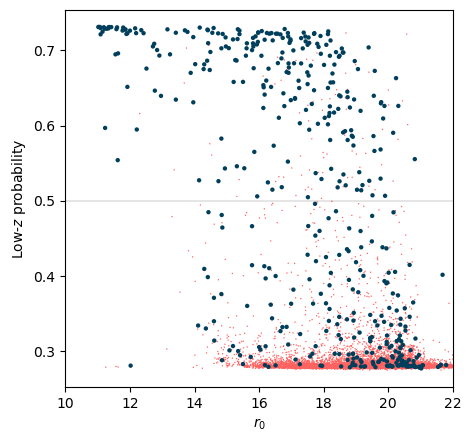

In [224]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

ax.scatter(df.R_MAG, df.pred_low_z, s=1, edgecolor='none', c=c3, label='SAGA S2 selection')
ax.scatter(df[df.SPEC_Z < 0.03].R_MAG, df[df.SPEC_Z < 0.03].pred_low_z, s=10, edgecolor='none', c=c0, label='Confirmed low-$z$ galaxies')

ax.axhline(0.5, color='k', alpha=0.1)

ax.set_ylabel('Low-$z$ probability')
ax.set_xlabel(r'$r_0$')

ax.set_xlim(10, 22);

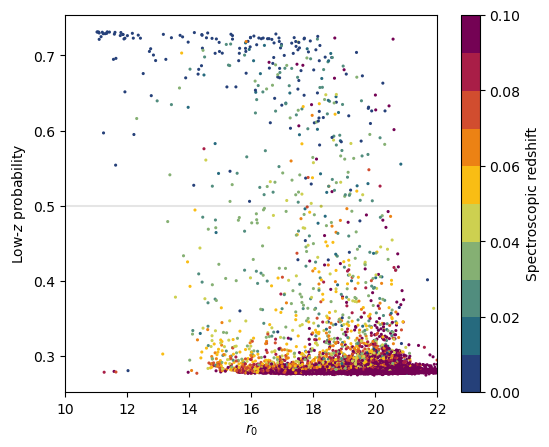

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=100)

cmap = ListedColormap(cmr.pride(np.linspace(0.12, 0.88, 10)))
sc = ax.scatter(df.R_MAG, df.pred_low_z, s=5, edgecolor='none', c=df.SPEC_Z, vmin=0, vmax=0.1, cmap=cmap)

ax.axhline(0.5, color='k', alpha=0.1)

ax.set_ylabel('Low-$z$ probability')
ax.set_xlabel(r'$r_0$')

ax.set_xlim(10, 22)
# ax.set_ylim(0.25, 0.75)

cb = fig.colorbar(sc, pad=0.05)
cb.set_label(r'Spectroscopic redshift')


## Measure purity, completeness, and accuracy, as a function of $r_0$, assuming decision boundary of 0.5

In [142]:
mag_range = np.arange(11.5, 22.5, 1)

low_z_purity = np.array(
    [
        sum((df[(df.R_MAG > r1) & (df.R_MAG <= r2)].SPEC_Z < 0.03) & (df[(df.R_MAG > r1) & (df.R_MAG <= r2)].pred_low_z > 0.5))
                / sum(df[(df.R_MAG > r1) & (df.R_MAG <= r2)].pred_low_z > 0.5) 
            for r1, r2 in zip(mag_range[:-1], mag_range[1:])
    ]
)

low_z_completeness = np.array(
    [
        sum((df[(df.R_MAG > r1) & (df.R_MAG <= r2)].SPEC_Z < 0.03) & (df[(df.R_MAG > r1) & (df.R_MAG <= r2)].pred_low_z > 0.5))
                / sum(df[(df.R_MAG > r1) & (df.R_MAG <= r2)].SPEC_Z < 0.03) 
            for r1, r2 in zip(mag_range[:-1], mag_range[1:])
    ]
)

low_z_accuracy = np.array(
    [
        (
            sum((df[(df.R_MAG > r1) & (df.R_MAG <= r2)].SPEC_Z < 0.03) & (df[(df.R_MAG > r1) & (df.R_MAG <= r2)].pred_low_z > 0.5)) 
           + sum((df[(df.R_MAG > r1) & (df.R_MAG <= r2)].SPEC_Z > 0.03) & (df[(df.R_MAG > r1) & (df.R_MAG <= r2)].pred_low_z < 0.5)) 
        )
                / sum((df.R_MAG > r1) & (df.R_MAG <= r2)) 
            for r1, r2 in zip(mag_range[:-1], mag_range[1:])
    ]
)

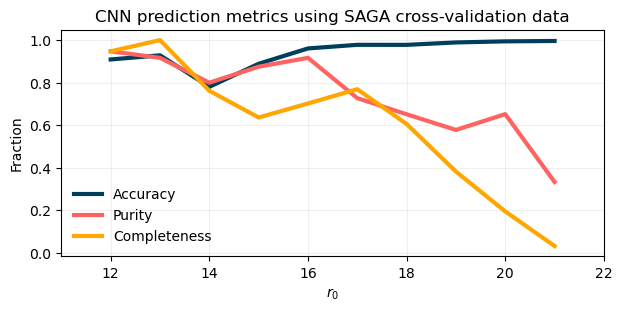

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=100)


ax.plot(mag_range[:-1]+0.5, low_z_accuracy, c=c0, lw=3, label='Accuracy')
ax.plot(mag_range[:-1]+0.5, low_z_purity, c=c3, lw=3, label='Purity')
ax.plot(mag_range[:-1]+0.5, low_z_completeness, c=c4, lw=3, label='Completeness')

ax.grid(alpha=0.2)

ax.legend(framealpha=0)

ax.set_xlim(11, 22)
ax.set_xlabel(r'$r_0$')
ax.set_ylabel('Fraction')

ax.set_title('CNN prediction metrics using SAGA cross-validation data');